## 1. Implementing a CNN from Scratch (40 points)

### 1.1. Introduction
* Brief overview of the task.
* Answer the questions like, What are the main components of a CNN architecture?, Why we use this in image classification?, etc.
* Description of the dataset used for classification.

In the given task, first of all we will implement a Convolutional Neural Network (CNN) from scratch using the PyTorch framework. Then we will apply transfer learning techniques using pre-trained architectures (ResNet-18 and MobileNet)

Main components:

Convolutional Layers: These are filters applied to the input image. The resulting result is called activation maps. Their primary purpose is to detect specific features such as edges, textures, or corners.

Activation Functions: These add non-linearity to the result from the convolutional layer and enable it to learn complex boundaries.

Pooling Layers: These layers reduce the spatial dimensions of the output of convolutional layers (feature maps) while making the network more robust.

We will use subset of Vegetable Image Dataset as our training data set. From 4500, we will use 3000 of them as training data set, 750 of them as validation set and 750 of them test set. We have 15 labels for this dataset

### 1.2. Data Loading and Preprocessing (3 points)

In [1]:
## Import necessary libraries
import os
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import pandas as pd
from sklearn.metrics import accuracy_score, f1_score,  precision_score, recall_score, confusion_matrix
import numpy as np
import seaborn as sns
from torchvision import models 

In [3]:
## Load the dataset using PyTorch's data loading utilities
## Apply necessary preprocessing such as resizing and normalization
## Divide the dataset into training, validation, and testing subsets

In [2]:
# Load training and validation directories
train_dir = 'train'
val_dir = 'val'

In [4]:
# Use GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [5]:
# Do validation dataset resizing and normalization
val_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # Normalization using ImageNet statistics
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# Do train dataset resizing and normalization
train_transform = transforms.Compose([
    transforms.Resize((256, 256)),
 
    transforms.RandomHorizontalFlip(p=0.5), 
    transforms.RandomRotation(10),
    transforms.ToTensor(),
     # Normalization using ImageNet statistics
    transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])
])

# Create datasets with transforms using ImageFolder
train_dataset = torchvision.datasets.ImageFolder(root=train_dir, transform=train_transform)
val_dataset = torchvision.datasets.ImageFolder(root=val_dir, transform=val_transform)

# Batch size selection
BATCH_SIZE = 15

# Data loaders for training and validation
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
len(train_dataset.classes)
train_dataset.classes




['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

### 1.3. Define your CNN architecture (7 points)
* Explain the reason behind your architecture.
* Explain your choice of activation functions.

First, I used ImageNet means and stds when normalizing the image input because I thought the trained model would have a similar distribution. This ensures a more stable training process.

I used RandomRotation(10) to make the model robust to slight camera angle variations. This prevents overfitting.

I selected a batch size of 15 because it gives better accuracy than 30 and is exactly divisible by the number of images in our training dataset, 3000. Another reason for this small batch size is that generalization is better at lower batch sizes.

The learning rate was set to 0.0005 for stable convergence with the Adam optimizer. I used a relatively high epoch number because I chose this low number as a learning rate.

Finally, I trained for 100 epochs to ensure that the relatively small dataset allows the model to fully converge. Since the best model was based on validation accuracy, a larger epoch count did not cause overfitting.

When designing my architecture, I tried to emulate the VGG model. I gradually increased the number of filters because I wanted it to better learn the properties of the filters. I used 3×3 convolutions with padding = 1 to preserve spatial dimensions after each convolution. Another reason I chose this was that the VGG architecture also uses this filter in every layer. I thought it would converge better.

I used Max Pooling after every convolutional layer except for a few layers. The reason I used it in certain layers and not others was experimental. This method yielded better accuracy. I used global average pooling before the final fully connected layer to reduce the spatial dimensions to a 512-dimensional feature vector. I used it because it helps prevent overfitting.

I applied Batch Normalization after each layer because it makes the network more robust.


ReLU:

I used ReLU after each convolutional layer because it gives non-linearity and it is very helpful for gradient computation. In combination with Batch Normalization, ReLU allows the network to train faster

In [6]:
## Design a CNN architecture with at least 3 and at most 6 convolutional layers
## Add activation functions (e.g., ReLU) after each convolutional layer
## Intersperse pooling layers (e.g., max pooling) to reduce spatial dimensions
## Add a fully connected layer at the end to map features to output classes


# Number of output classes
num_classes = 15

# CNN architecture designed with 5 convolutional layers +
# batch normalization + ReLU activations + pooling
model = nn.Sequential(
         
            nn.Conv2d(3, 32, kernel_size=3, padding=1), # First Convolution Layer
            nn.BatchNorm2d(32),
            nn.ReLU(), 
            nn.MaxPool2d(2, 2), # Reduces spatial size 256 -> 128

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # 128 -> 64

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),  # 64 -> 32
            
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
           
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),

            # Global average pooling
            nn.AdaptiveAvgPool2d((1, 1)),

            nn.Flatten(), 
            
            # Final fully connected layer for classification
            nn.Linear(512, num_classes)
        )

model = model.to(device) 

### 1.4 Prepare the model for training (3 points)
* Explain your choice of loss functions and optimization algorithms.

I chose Cross Entropy Loss because it's the standard and optimal loss for our problem (15-class classification) and for PyTorch. I didn't choose MSE loss because it wasn't suitable. It can't learn accurate decision boundaries for classification, and it converges slowly and poorly.

Secondly, I chose Adam Optimizer because it calculates a separate adaptive learning rate for each parameter. It's a more suitable optimizer for small datasets like ours. If we had chosen SGD for this dataset, it would have converged slower. Finally, Adam Optimizer is more suitable for the relatively low learning rate I chose.

In [7]:
## Choose an optimizer (SGD or Adam) and set its parameters (e.g., learning rate)

# CrossEntropyLoss is used
criterion = nn.CrossEntropyLoss()

# Learning rate declaration
learning_rate = 0.0005 

# Adam optimizer is chosen
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# num of epochs
num_epochs = 100

### 1.5 Train and Validate the CNN model (10 points)

In [8]:
## Iterate over the training dataset in mini-batches
## Implement forward pass, compute loss, and backward pass for gradient computation
## Update model parameters using the optimizer based on computed gradients
## Validate the model on the validation set periodically and plot the validation loss
## Repeat the training process for a suitable number of epochs (at least 30epochs)


# Arrays that hold the metrics we will display at the end of each epoch
train_losses = np.zeros(num_epochs)
val_losses   = np.zeros(num_epochs)
train_accs   = np.zeros(num_epochs)
val_accs     = np.zeros(num_epochs)

# For sving the best model
best_acc = 0.0

# Epoch for loop
for epoch in range(num_epochs):
    
    # Train Mode
    model.train()
    running_loss = 0.0 # For loss calculation each epoch
    batch_correct = [] # will hold number of correct predictions per batch  
    batch_sizes = [] # will hold batch sizes

    # Iterate over all mini-batches in the training set
    for i, (images, labels) in enumerate(train_loader):

        # Move data to GPU
        images = images.to(device)
        labels = labels.to(device)

        # Reset gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)      

        # Compute loss        
        loss = criterion(outputs, labels)    
        loss.backward() # Backward pass                       
        optimizer.step()   # Update model parameters                    

         # Accumulate total loss for each epoch
        running_loss += loss.item()  * images.size(0)

        # Batchh size and correct outputs in batch calc
        label_size1 = labels.size(0)
        batch_sizes.append(label_size1)
        preds = outputs.argmax(dim=1)
        sum1 = (preds == labels).sum()
        batch_correct.append(sum1.item())

    # Compute training accuracy and loss
    epoch_train_loss = running_loss / len(train_dataset)
    epoch_train_acc = sum(batch_correct) / sum(batch_sizes)

  
    # Evaluation mode 
    model.eval()


    batch_correct_val = [] # will hold number of correct predictions per batch 
    batch_sizes_val = [] # will hold batch sizes
    val_running_loss  = 0.0 # For loss calculation each epoch


    # Do not compute gradient
    with torch.no_grad():
        # Iterate over all mini-batches
        for i, (images, labels) in enumerate(val_loader):
            # Move data to GPU
            images = images.to(device)
            labels = labels.to(device)

             # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels) # Compute validation loss
            
            # Accumulate validation loss 
            val_running_loss += loss.item()  * images.size(0) 

            # Compute predictions and count how many are correct
            preds = outputs.argmax(dim=1)
            sum2 = (preds == labels).sum()
            batch_correct_val.append(sum2.item())
            label_size = labels.size(0)
            batch_sizes_val.append(label_size)

     # Compute average validation loss and accuracu
    epoch_val_loss = val_running_loss / len(val_dataset)
    epoch_val_acc  = sum(batch_correct_val) / sum(batch_sizes_val)



    # Save metric into numpy arrays
    train_losses[epoch] = epoch_train_loss
    val_losses[epoch]   = epoch_val_loss
    train_accs[epoch]   = epoch_train_acc
    val_accs[epoch]     = epoch_val_acc


     # Print
    print(
    "Epoch " + str(epoch+1) + "/" + str(num_epochs) + "\n" +
    "Train Loss: " + str(epoch_train_loss) + " | Train Acc: " + str(epoch_train_acc) + "\n" +
    "Val Loss: " + str(epoch_val_loss)   + " | Val Acc: " + str(epoch_val_acc)   + "\n"
    )

    # Save best model if there is at the end of each epoch
    if epoch_val_acc > best_acc:
        best_acc = epoch_val_acc
        torch.save(model.state_dict(), 'best_model.pth')
print(best_acc)

Epoch 1/100
Train Loss: 1.44149223446846 | Train Acc: 0.5653333333333334
Val Loss: 1.0394748848676683 | Val Acc: 0.6586666666666666

Epoch 2/100
Train Loss: 0.9359267872571945 | Train Acc: 0.716
Val Loss: 0.6739267940819264 | Val Acc: 0.7946666666666666

Epoch 3/100
Train Loss: 0.7616327865421773 | Train Acc: 0.764
Val Loss: 0.7003462121635675 | Val Acc: 0.7733333333333333

Epoch 4/100
Train Loss: 0.6356943802908063 | Train Acc: 0.8046666666666666
Val Loss: 0.45581750094890594 | Val Acc: 0.868

Epoch 5/100
Train Loss: 0.5562449155747891 | Train Acc: 0.8356666666666667
Val Loss: 0.3998541905730963 | Val Acc: 0.8666666666666667

Epoch 6/100
Train Loss: 0.5181251624599099 | Train Acc: 0.8403333333333334
Val Loss: 0.39421114839613436 | Val Acc: 0.8826666666666667

Epoch 7/100
Train Loss: 0.4493830137327313 | Train Acc: 0.863
Val Loss: 0.6113444366678595 | Val Acc: 0.8146666666666667

Epoch 8/100
Train Loss: 0.41513753702864054 | Train Acc: 0.8763333333333333
Val Loss: 0.4370725434832275 | 

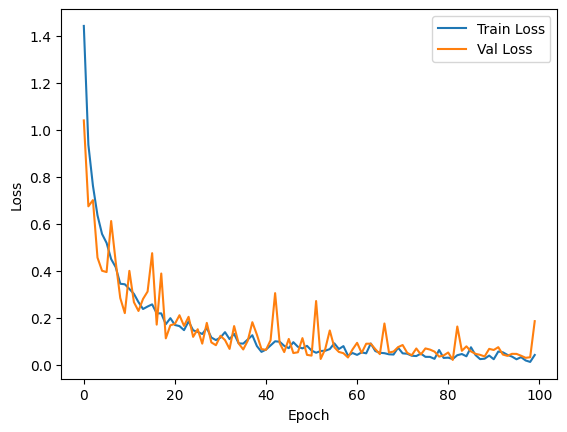

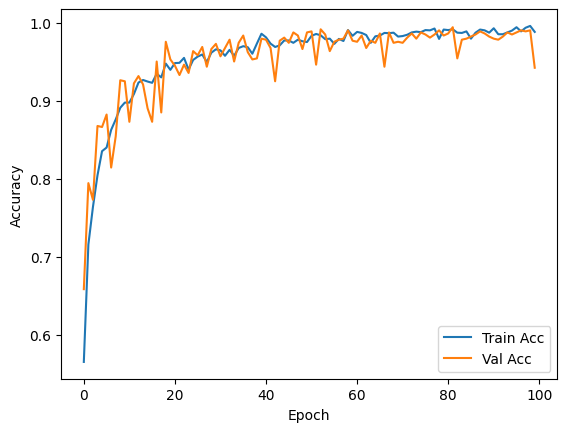

In [9]:
## You can conduct experiments with different hyperparameters to get the best performing model, considering you will be uploading your best model into Kaggle for compitation :)

# Plot loss and accuracy for epoch using saved numpy arrays


plt.figure()
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.plot(train_accs, label="Train Acc")
plt.plot(val_accs, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Mention about, why did you choose your learning rate and batch size?

I selected a batch size of 15 because it gives better accuracy than 30 and is exactly divisible by the number of images in our training dataset, 3000. Another reason for this small batch size is that generalization is better at lower batch sizes.

The learning rate was set to 0.0005 for stable convergence with the Adam optimizer. I used a relatively high epoch number because I chose this low number as a learning rate.

In [10]:
## Select your best model with respect to validation accuracy
## Visualize the accuracy and loss change of the best performing model across training and validation datasets.

## Compute metrics such as accuracy, precision, recall, and F1-score
## Visualize confusion matrix to understand the model's behavior across different classes


In [11]:
# Visualize confusion matrix for your best model to understand the model’s behavior across different classes

# Load best model for evaluation
model.load_state_dict(torch.load("best_model.pth", map_location=device))

# Eval mode
model.eval()

# Store predictions and targets for evaluation metrics
store_preds = []
store_targets = []

# Do not compute gradient
with torch.no_grad():
    for data, target in val_loader: # Iterate over all mini-batches

        # Move data to GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        out = model(data)
        
        _, prediction_indices = torch.max(out, 1)

        
        store_preds.append(prediction_indices)
        store_targets.append(target)

# Convert lists to numpy arrays
final_predictions = torch.cat(store_preds).cpu().numpy()
final_targets = torch.cat(store_targets).cpu().numpy()

# Compute evaluation metrics
acc = accuracy_score(final_targets, final_predictions)
prec = precision_score(final_targets, final_predictions, average='macro')
rec    = recall_score(final_targets, final_predictions, average='macro')
f1        = f1_score(final_targets, final_predictions, average='macro')

# Print
print("Validation :", acc)
print("Precision :", prec)
print("Recall :", rec)
print("F1 Score :", f1)


Validation : 0.9946666666666667
Precision : 0.9947712418300654
Recall : 0.9946666666666668
F1 Score : 0.9946794679467946


[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 49  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0  0 49  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  1  0  0  0  0  0  0  0 49  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  0  0 49]]


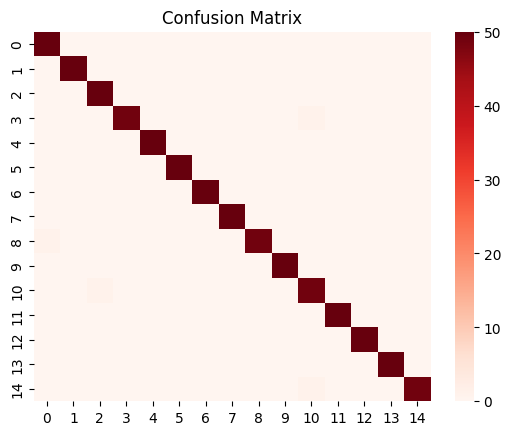

In [12]:
# Plot confusion matrix

cm = confusion_matrix(final_targets, final_predictions)
print(cm)

sns.heatmap(cm,  cmap='Reds')
plt.title("Confusion Matrix")

plt.show()

### 1.6 Evaluate the trained model on the test set (5 points)

In [13]:
test_transform = val_transform   # Test transform same as validation transform


# Custom dataset class for unlabeled test images 
class TestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform

        # Load only .jpg files
        self.image_files = []
        for filename in os.listdir(root_dir):
            if filename.lower().endswith(".jpg"):
                self.image_files.append(filename)

        self.image_files.sort()

    # Return the total number of test images.
    def __len__(self):
        length = len(self.image_files)
        return length

    def __getitem__(self, idx):
        name = self.image_files[idx]
        path = os.path.join(self.root_dir, name)
        # Load image and convert it to RGB 
        img = Image.open(path)
        img = img.convert("RGB")

        # Apply the same preprocessing pipeline used for validation
        img = self.transform(img) if self.transform else img

        return img, name


# Directory that contains test images
test_dir = 'test_unlabeled_v2'  
# Create the test dataset and dataloader
test_dataset = TestDataset(test_dir, transform=test_transform)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)



In [14]:

# Model is on the GPU and in evaluation mode
model.to(device)
model.eval()

# class_names maps predicted indices
class_names = train_dataset.classes  

ids = []
labels = []

# Disable gradient computation 
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device) # Move test images to device


        # Forward pass 
        outputs = model(images)

        # Get predicted class indices for each image
        preds = outputs.argmax(dim=1).cpu().numpy()


        # Convert indices into class names
        pred_names = []
        for p in preds:
            class_name_idx=class_names[p]
            pred_names.append(class_name_idx)

        # Add the batch results
        ids.extend(img_names)
        labels.extend(pred_names)

# Create a DataFrame in the format required by Kaggle:
submission_df = pd.DataFrame({
    "Id": ids,
    "label": labels
})
# Save the submission file
submission_df.to_csv("submission.csv", index=False)




### 1.7 Conclusion and interpretation (7 points)
* Summarize the performance of the model on the test set
* Discuss any challenges encountered during training and potential areas for improvement
* Reflect on the overall effectiveness of the chosen CNN architecture and training approach

My test result on Kaggle was 0.986. This is a good result. It shows that the model generalizes quite well. Although the validation score is slightly higher, it can be considered consistent with the validation score. Overall, the model achieved strong test performance based on the test results.

Because we used a relatively small dataset, the model was prone to overfitting, especially considering the number of epochs I used, which is 100. For this problem, I wrote code that records the best model based on accuracy. I also had some difficulty finding the most accurate learning rate because I experimented every each one. This part was challenging because each try took so long. 

For potential improvements, a dropout layer could have been added to reduce overfitting. I didn't add it because I didn't know if it was legal for this assignment. Another improvement could have been on the dataset; the model could have generalized better with more data.

Overall, the selected architecture proved effective for the vegetable classification task. Because it gave a very good score on the test set, which proves that the model is well designed and generalizes well.

### 1.8 Kaggle Test Result (5 points)
* Put your Kaggle test result for your CNN model here.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

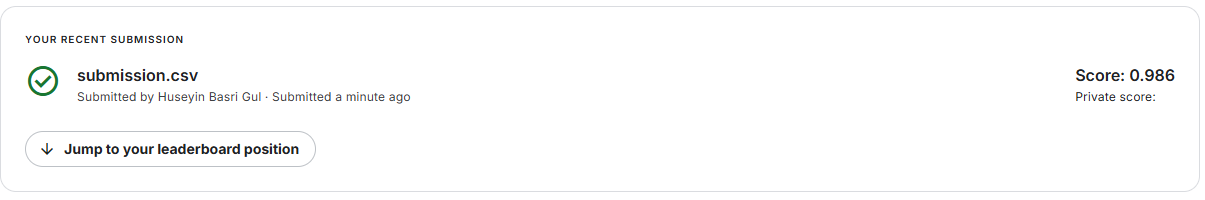

## 2. Exploring Transfer Learning with ResNet50 and MobileNet (60 points)

### 2.1. Introduction
* Brief overview of the task.
* Answer the questions like, What is fine-tuning? Why should we do this? Why do we freeze the rest and train only last layers?

Fine Tuning is a transfer learning technique in which all or some layers of the pre-trained model are retrained with a new dataset.

We need fine tuning because if we have a small dataset, we can't train a large network like a CNN with this small dataset. Pre-trained models learn general visual features, which makes it easier to train other layers. It converges better and faster than scratch training.

When we "freeze" layers, their weights are not updated during backpropagation. Since the first layers learn more general features, there's no need to retrain them. We train the last layers because they are more specific to the given task.

### 2.2. Load the pre-trained ResNet18 model (3 points)


In [15]:
## Utilize torchvision library to load the pre-trained ResNet50 model
## Ensure that the model's architecture matches ResNet50, by checking the model summary.
 

To avoid code duplication, I wrote a method that performs the same task for each model.

In [16]:

# Helper model for training and evaluation
def train_transfer_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=30):
    
    # Arrays to store metrics per epoch
    train_losses = np.zeros(num_epochs)
    val_losses   = np.zeros(num_epochs)
    train_accs   = np.zeros(num_epochs)
    val_accs     = np.zeros(num_epochs)

    # Epoch for loop
    for epoch in range(num_epochs):
        # Train Mode
        model.train()
        running_loss = 0.0  # For loss calculation each epoch
        batch_correct = []  # will hold number of correct predictions per batch
        batch_sizes = [] # will hold batch sizes

        # Iterate over all mini-batches
        for i, (images, labels) in enumerate(train_loader):

            #Move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            # Reset gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)             

            # Loss calculation 
            loss = criterion(outputs, labels)    
            loss.backward()     # Backward pass                 
            optimizer.step()                     

            
            running_loss += loss.item() * images.size(0)# Update model parameters                    

         
            # Accumulate total loss for each epoch
            label_size1 = labels.size(0)
            batch_sizes.append(label_size1)
            preds = outputs.argmax(dim=1)
            sum1 = (preds == labels).sum()
            batch_correct.append(sum1.item())
    
        # Compute training accuracy and loss
        epoch_train_loss = running_loss / len(train_loader.dataset)
        epoch_train_acc = sum(batch_correct) / sum(batch_sizes)
        
        # Evaluation mode
        model.eval()
        batch_correct_val = []# will hold number of correct predictions per batch 
        batch_sizes_val = [] # will hold batch sizes
        val_running_loss  = 0.0 # For loss calculation each epoch

        # Iterate over all mini-batches
        with torch.no_grad():
            for i, (images, labels) in enumerate(val_loader):
                # Move data to GPU
                images = images.to(device)
                labels = labels.to(device)

                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)# Compute validation loss

                val_running_loss += loss.item() * images.size(0) # Accumulate validation loss 

                # Compute predictions and count how many are correct
                preds = outputs.argmax(dim=1)
                sum2 = (preds == labels).sum()
                batch_correct_val.append(sum2.item())
                
                label_size = labels.size(0)
                batch_sizes_val.append(label_size)

        # Compute average validation loss and accuracu
        epoch_val_loss = val_running_loss / len(val_loader.dataset)
        epoch_val_acc  = sum(batch_correct_val) / sum(batch_sizes_val)

         # Save metric into numpy arrays
        train_losses[epoch] = epoch_train_loss
        val_losses[epoch]   = epoch_val_loss
        train_accs[epoch]   = epoch_train_acc
        val_accs[epoch]     = epoch_val_acc
        # Print
        print(
            "Epoch " + str(epoch+1) + "/" + str(num_epochs) + "\n" +
            "Train Loss: " + f"{epoch_train_loss:.4f}" + " | Train Acc: " + f"{epoch_train_acc:.4f}" + "\n" +
            "Val Loss: " + f"{epoch_val_loss:.4f}"   + " | Val Acc: " + f"{epoch_val_acc:.4f}"   + "\n"
        )

    return model, train_losses,val_losses, train_accs,val_accs




### 2.3 Modify the ResNet18 model for transfer learning (15 points)

In [17]:
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified ResNet18 model on the vegetable image dataset. (base model)


# Load the pre-trained ResNet-18 model
model_res1 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


# Freeze all layers of the network.
for param in model_res1.parameters():
    param.requires_grad = False


# Unfreeze the final fully connected (FC) layer.
for param in model_res1.fc.parameters():
    param.requires_grad = True


# Replace the original FC layer.
num_ftrs = model_res1.fc.in_features
model_res1.fc = nn.Linear(num_ftrs, num_classes) 

# Print the model architecture 
print(model_res1)


model_res1 = model_res1.to(device)

# Define the loss function.
criterion_res1 = nn.CrossEntropyLoss()

# Define optimizer
optimizer_res1 = optim.Adam(model_res1.fc.parameters(), lr=0.001)

# Train the model using our helper function.
model_res1,  train_losses_res1,val_losses_res1, train_accs_res1,val_accs_res1 = train_transfer_model(
    model       = model_res1,
    train_loader= train_loader, 
    val_loader  = val_loader,   
    criterion   = criterion_res1,
    optimizer   = optimizer_res1,
    num_epochs  = 43,
)


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

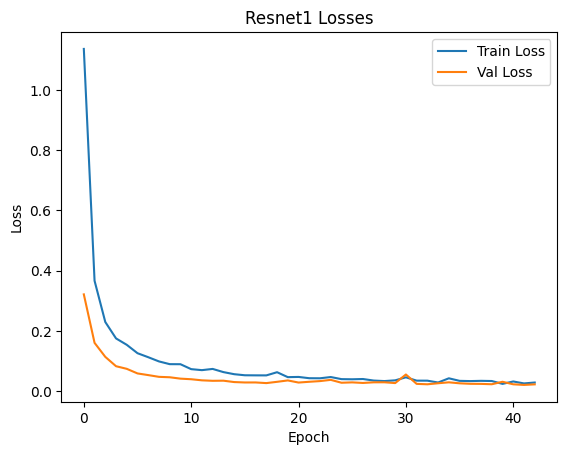

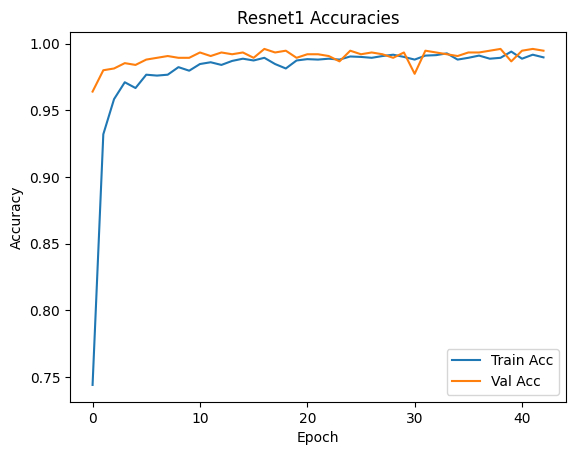

In [18]:
## You can conduct experiments with different hyperparameters to get the best performing model, considering you will be uploading your best model into Kaggle for compitation :)


# Plot loss and accuracy for epoch using saved numpy arrays

plt.figure()
plt.title("Resnet1 Losses")
plt.plot(train_losses_res1, label="Train Loss")
plt.plot(val_losses_res1, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.title("Resnet1 Accuracies")
plt.plot(train_accs_res1, label="Train Acc")
plt.plot(val_accs_res1, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [19]:
model_res1.eval()# Eval mode

# Store predictions and targets for evaluation metrics
store_preds = []
store_targets = []

# Do not compute gradient
with torch.no_grad():
    for data, target in val_loader: # Iterate over all mini-batches

        # Move data to GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        out = model_res1(data)
        
        _, prediction_indices = torch.max(out, 1)

        
        store_preds.append(prediction_indices)
        store_targets.append(target)

# Convert lists to numpy arrays
final_predictions = torch.cat(store_preds).cpu().numpy()
final_targets = torch.cat(store_targets).cpu().numpy()

# Compute evaluation metrics
acc = accuracy_score(final_targets, final_predictions)
prec = precision_score(final_targets, final_predictions, average='macro')
rec    = recall_score(final_targets, final_predictions, average='macro')
f1        = f1_score(final_targets, final_predictions, average='macro')

# Print
print("Validation :", acc)
print("Precision :", prec)
print("Recall :", rec)
print("F1 Score :", f1)





Validation : 0.9946666666666667
Precision : 0.9947450980392157
Recall : 0.9946666666666668
F1 Score : 0.9946662666266628


[[49  0  0  0  0  0  0  0  0  0  0  0  0  0  1]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 49  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 49  0  0  0  0]
 [ 0  0  0  0  0  0  0  1  0  0  0 49  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 50]]


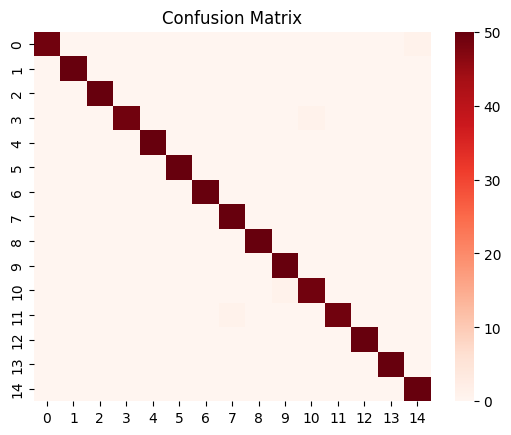

In [20]:
# Plot confusion matrix

cm = confusion_matrix(final_targets, final_predictions)
print(cm)

sns.heatmap(cm,  cmap='Reds')
plt.title("Confusion Matrix")
plt.show()

In [21]:
## Define another ResNet18 model
## Freeze all layers of the ResNet18 model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Unfreeze convolutional layers 3 and 4 of the ResNet18 model and again proceed with training. (second model)


# Load the pre-trained ResNet-18 model
model_res2 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)

# Freeze all layers of the network.
for param in model_res2.parameters():
    param.requires_grad = False

# Unfreeze the final fully connected (FC) layer and layer 3 and 4
num_ftrs_2 = model_res2.fc.in_features
model_res2.fc = nn.Linear(num_ftrs_2, num_classes)   


for param in model_res2.layer3.parameters():
    param.requires_grad = True

for param in model_res2.layer4.parameters():
    param.requires_grad = True

for param in model_res2.fc.parameters():
    param.requires_grad = True

model_res2 = model_res2.to(device)

# Define the loss function.
criterion_res2 = nn.CrossEntropyLoss()


trainable_params_res2 = []   


# Define optimizer
for param in model_res2.parameters():   
    if param.requires_grad:            
        trainable_params_res2.append(param)   

optimizer_res2 = optim.Adam(trainable_params_res2, lr=1e-4)  

# Train the model using our helper function.
model_res2, train_losses_res2, val_losses_res2, train_accs_res2, val_accs_res2 = train_transfer_model(
    model        = model_res2,
    train_loader = train_loader,
    val_loader   = val_loader,
    criterion    = criterion_res2,
    optimizer    = optimizer_res2,
    num_epochs   = 43,
    
)



Epoch 1/43
Train Loss: 0.4148 | Train Acc: 0.9173
Val Loss: 0.0243 | Val Acc: 0.9973

Epoch 2/43
Train Loss: 0.0509 | Train Acc: 0.9927
Val Loss: 0.0133 | Val Acc: 0.9973

Epoch 3/43
Train Loss: 0.0258 | Train Acc: 0.9973
Val Loss: 0.0068 | Val Acc: 1.0000

Epoch 4/43
Train Loss: 0.0329 | Train Acc: 0.9917
Val Loss: 0.0313 | Val Acc: 0.9920

Epoch 5/43
Train Loss: 0.0291 | Train Acc: 0.9940
Val Loss: 0.0099 | Val Acc: 0.9960

Epoch 6/43
Train Loss: 0.0111 | Train Acc: 0.9993
Val Loss: 0.0053 | Val Acc: 0.9987

Epoch 7/43
Train Loss: 0.0157 | Train Acc: 0.9967
Val Loss: 0.0042 | Val Acc: 1.0000

Epoch 8/43
Train Loss: 0.0098 | Train Acc: 0.9990
Val Loss: 0.0049 | Val Acc: 0.9987

Epoch 9/43
Train Loss: 0.0121 | Train Acc: 0.9973
Val Loss: 0.0066 | Val Acc: 0.9973

Epoch 10/43
Train Loss: 0.0200 | Train Acc: 0.9937
Val Loss: 0.0176 | Val Acc: 0.9947

Epoch 11/43
Train Loss: 0.0140 | Train Acc: 0.9977
Val Loss: 0.0040 | Val Acc: 1.0000

Epoch 12/43
Train Loss: 0.0177 | Train Acc: 0.9950
V

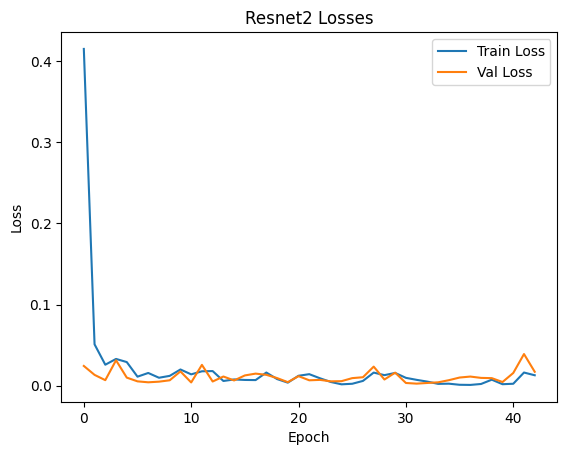

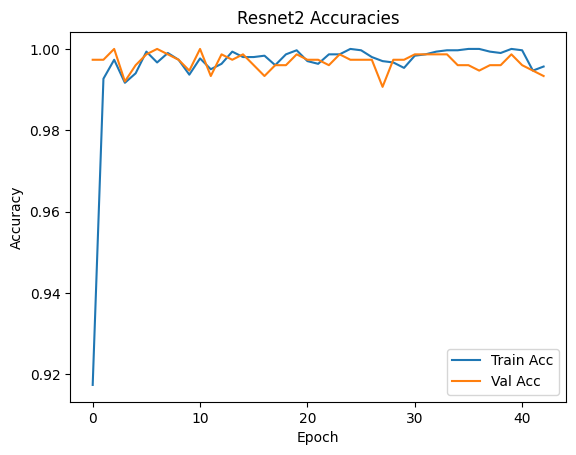

In [22]:
# Plot loss and accuracy for epoch using saved numpy arrays
plt.figure()
plt.title("Resnet2 Losses")
plt.plot(train_losses_res2, label="Train Loss")
plt.plot(val_losses_res2, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.title("Resnet2 Accuracies")
plt.plot(train_accs_res2, label="Train Acc")
plt.plot(val_accs_res2, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [23]:
model_res2.eval()# Eval mode

# Store predictions and targets for evaluation metrics
store_preds = []
store_targets = []

# Do not compute gradient
with torch.no_grad():
    for data, target in val_loader:# Iterate over all mini-batches

        # Move data to GPU
        data = data.to(device)
        target = target.to(device)
        # Forward pass
        out = model_res2(data)
        
        _, prediction_indices = torch.max(out, 1)

        
        store_preds.append(prediction_indices)
        store_targets.append(target)

# Convert lists to numpy arrays
final_predictions = torch.cat(store_preds).cpu().numpy()
final_targets = torch.cat(store_targets).cpu().numpy()

# Compute evaluation metrics
acc = accuracy_score(final_targets, final_predictions)
prec = precision_score(final_targets, final_predictions, average='macro')
rec    = recall_score(final_targets, final_predictions, average='macro')
f1        = f1_score(final_targets, final_predictions, average='macro')

# Print
print("Validation :", acc)
print("Precision :", prec)
print("Recall :", rec)
print("F1 Score :", f1)





Validation : 0.9933333333333333
Precision : 0.9935394670688787
Recall : 0.9933333333333334
F1 Score : 0.9933302325583276


[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0 49  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0 49  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  3  0  0  0  0  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 50]]


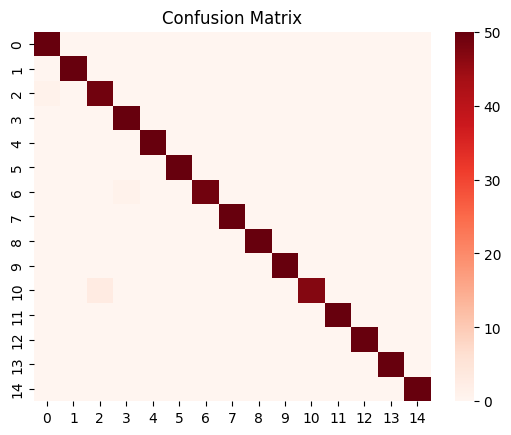

In [24]:
# Plot confusion matrix
cm = confusion_matrix(final_targets, final_predictions)
print(cm)

sns.heatmap(cm,  cmap='Reds')
plt.title("Confusion Matrix")

plt.show()

In [25]:
## Define another ResNet18 model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (third model)

# Load the pre-trained ResNet-18 model
model_res3 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)


num_ftrs_3 = model_res3.fc.in_features
model_res3.fc = nn.Linear(num_ftrs_3, num_classes)

# Unfreeze all layers
for param in model_res3.parameters():
    param.requires_grad = True

model_res3 = model_res3.to(device)

# Define the loss function.
criterion_res3 = nn.CrossEntropyLoss()
optimizer_res3 = optim.Adam(model_res3.parameters(), lr=1e-4) # Define optimizer

# Train the model using our helper function.
model_res3, train_losses_res3, val_losses_res3, train_accs_res3, val_accs_res3 = train_transfer_model(
    model        = model_res3,
    train_loader = train_loader,
    val_loader   = val_loader,
    criterion    = criterion_res3,
    optimizer    = optimizer_res3,
    num_epochs   = 43,

)



Epoch 1/43
Train Loss: 0.4250 | Train Acc: 0.9077
Val Loss: 0.0284 | Val Acc: 0.9987

Epoch 2/43
Train Loss: 0.0628 | Train Acc: 0.9890
Val Loss: 0.0205 | Val Acc: 0.9947

Epoch 3/43
Train Loss: 0.0387 | Train Acc: 0.9943
Val Loss: 0.0091 | Val Acc: 0.9987

Epoch 4/43
Train Loss: 0.0199 | Train Acc: 0.9977
Val Loss: 0.0127 | Val Acc: 0.9973

Epoch 5/43
Train Loss: 0.0250 | Train Acc: 0.9947
Val Loss: 0.0082 | Val Acc: 0.9987

Epoch 6/43
Train Loss: 0.0180 | Train Acc: 0.9963
Val Loss: 0.0084 | Val Acc: 0.9973

Epoch 7/43
Train Loss: 0.0387 | Train Acc: 0.9920
Val Loss: 0.0186 | Val Acc: 0.9933

Epoch 8/43
Train Loss: 0.0244 | Train Acc: 0.9953
Val Loss: 0.0069 | Val Acc: 1.0000

Epoch 9/43
Train Loss: 0.0174 | Train Acc: 0.9967
Val Loss: 0.0209 | Val Acc: 0.9933

Epoch 10/43
Train Loss: 0.0149 | Train Acc: 0.9963
Val Loss: 0.0075 | Val Acc: 0.9987

Epoch 11/43
Train Loss: 0.0091 | Train Acc: 0.9983
Val Loss: 0.0055 | Val Acc: 0.9973

Epoch 12/43
Train Loss: 0.0268 | Train Acc: 0.9920
V

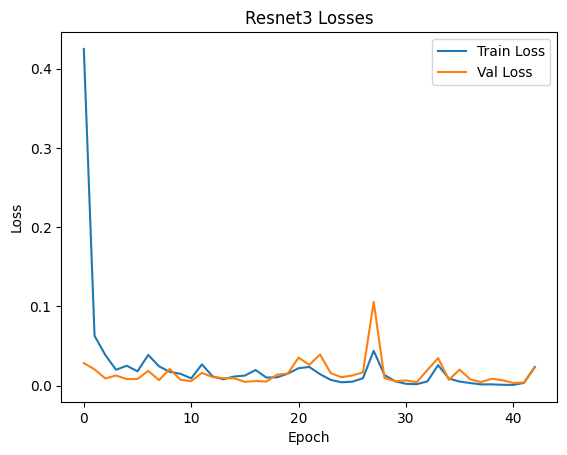

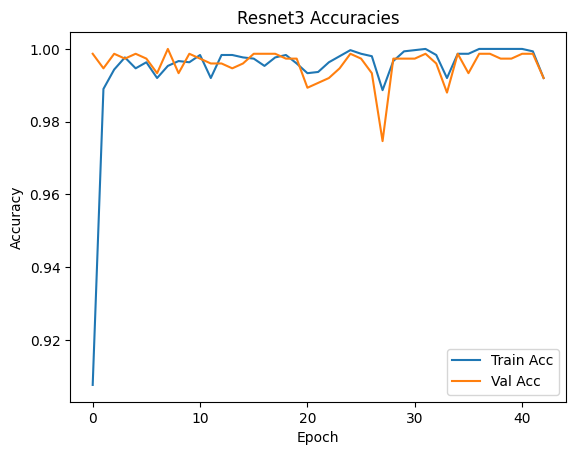

In [26]:

## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes


# Plot loss and accuracy for epoch using saved numpy arrays
plt.figure()
plt.title("Resnet3 Losses")
plt.plot(train_losses_res3, label="Train Loss")
plt.plot(val_losses_res3, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.title("Resnet3 Accuracies")
plt.plot(train_accs_res3, label="Train Acc")
plt.plot(val_accs_res3, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()



In [27]:
model_res3.eval()
# Eval mode


# Store predictions and targets for evaluation metrics
store_preds = []
store_targets = []


# Do not compute gradient
with torch.no_grad():
    for data, target in val_loader:# Iterate over all mini-batches

        # Move data to GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        out = model_res3(data)
        
        _, prediction_indices = torch.max(out, 1)

        
        store_preds.append(prediction_indices)
        store_targets.append(target)

# Convert lists to numpy arrays
final_predictions = torch.cat(store_preds).cpu().numpy()
final_targets = torch.cat(store_targets).cpu().numpy()

# Compute evaluation metrics
acc = accuracy_score(final_targets, final_predictions)
prec = precision_score(final_targets, final_predictions, average='macro')
rec    = recall_score(final_targets, final_predictions, average='macro')
f1        = f1_score(final_targets, final_predictions, average='macro')

# Print
print("Validation :", acc)
print("Precision :", prec)
print("Recall :", rec)
print("F1 Score :", f1)





Validation : 0.992
Precision : 0.9922574157868276
Recall : 0.9919999999999999
F1 Score : 0.9919975991196559


[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 48  1  0  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0 49  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 50  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  1  0  0  1  0  0  0 48  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1  0  0 49]]


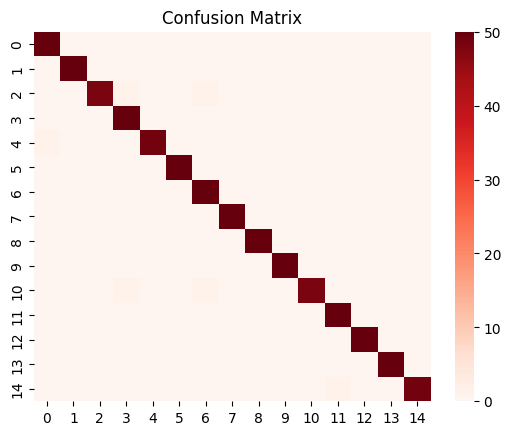

In [28]:

# Plot confusion matrix
cm = confusion_matrix(final_targets, final_predictions)
print(cm)

sns.heatmap(cm,  cmap='Reds')
plt.title("Confusion Matrix")

plt.show()

Conduct a comparative analysis among these three models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

The best performance was achieved by the third model because fine tuning all layers allows it to fully learn the characteristics of the vegetable dataset. All weights were updated, so the model learned the most optimal features for this specific dataset.

Only FC Layer Trained (Model 1) had the shortest training time because we trained a single layer. However, because not all features were updated, it scored lower compared to the other models. This model had the least GPU usage. It has the least risk of overfitting.

Model 2 had a moderate training time. It had more GPU usage and higher accuracy than Model 1. The risk of overfitting was also higher than Model 1.

Model 3 had the longest training time and the highest accuracy. This is because we trained all layers. GPU usage was the highest. It also had the highest risk of overfitting.

In cases where the dataset is small, meaning the model is prone to overfitting, and in cases where time and GPU resources are limited, Model 1 will be more suitable.

In cases where the dataset is large and resources are plentiful, Model 3 will be the best option.

### 2.4 Evaluate the fine-tuned ResNet18 model (5 points)

In [29]:
## Test the best model on the test set to evaluate its performance.
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch


# Model is on the GPU and in evaluation mode
model_res3.to(device)
model_res3.eval()

# class_names maps predicted indices
class_names = train_dataset.classes   

ids = []
labels = []

# Disable gradient computation 
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device)# Move test images to device

        # Forward pass 
        outputs = model_res3(images)

        # Get predicted class indices for each image
        preds = outputs.argmax(dim=1).cpu().numpy()

        # Convert indices into class names
        pred_names = []
        for p in preds:
            class_name_idx=class_names[p]
            pred_names.append(class_name_idx)

        # Add the batch results
        ids.extend(img_names)
        labels.extend(pred_names)


# Create a DataFrame in the format required by Kaggle:
submission_df = pd.DataFrame({
    "Id": ids,
    "label": labels
})

# Save the submission file
submission_df.to_csv("submission_resnet.csv", index=False)



### 2.5 Kaggle Test Result (5 points)
* Put your Kaggle test result for your ResNet-18 pretrained model here.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

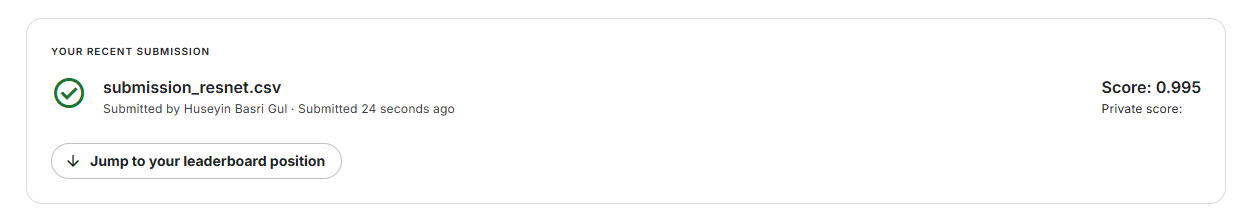

### 2.7. Load the pre-trained MobileNet model (3 points)


In [30]:
## Utilize torchvision library to load the pre-trained MobileNetV2 model
## Ensure that the model's architecture matches MobileNetV2, by checking the model summary.


### 2.8 Modify the MobileNet model for transfer learning (12 points)

In [31]:
## Freeze all layers of the MobileNet model.
## Replace the final fully connected layer with a new FC layer matching the number of classes
## Unfreeze the final FC layer
## Define appropriate loss function and optimizer for training
## Train the modified MobileNet model on the vegetable image dataset. (base model)

# Load the pre-trained MobileNet model
model_mob1 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1)


# Freeze all layers of the network.
for param in model_mob1.parameters():
    param.requires_grad = False


# Unfreeze the final fully connected (FC) layer
in_features_m1 = model_mob1.classifier[1].in_features
model_mob1.classifier[1] = nn.Linear(in_features_m1, num_classes)  

for param in model_mob1.classifier.parameters():
    param.requires_grad = True


print(model_mob1)  

model_mob1 = model_mob1.to(device)

# Define the loss function.
criterion_mob1 = nn.CrossEntropyLoss()
optimizer_mob1 = optim.Adam(model_mob1.classifier.parameters(), lr=1e-3) # Define optimizer

# Train the model using our helper function.
model_mob1, train_losses_mob1, val_losses_mob1, train_accs_mob1, val_accs_mob1 = train_transfer_model(
    model        = model_mob1,
    train_loader = train_loader,
    val_loader   = val_loader,
    criterion    = criterion_mob1,
    optimizer    = optimizer_mob1,
    num_epochs   = 43,
)



MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

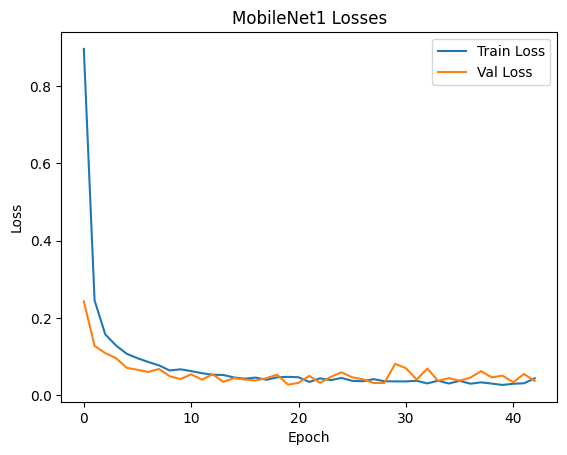

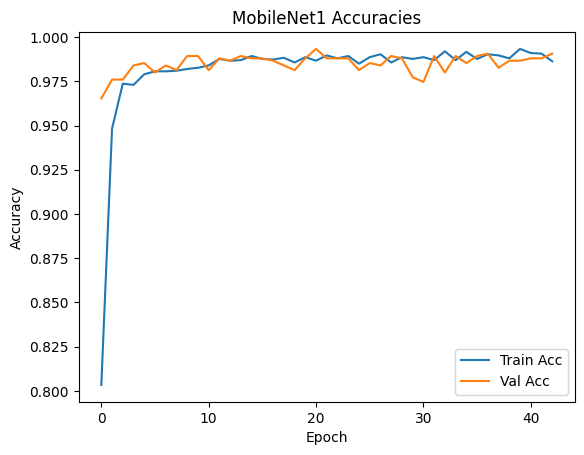

In [32]:
# Plot loss and accuracy for epoch using saved numpy arrays
plt.figure()
plt.title("MobileNet1 Losses")
plt.plot(train_losses_mob1, label="Train Loss")
plt.plot(val_losses_mob1, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.title("MobileNet1 Accuracies")
plt.plot(train_accs_mob1, label="Train Acc")
plt.plot(val_accs_mob1, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [33]:
model_mob1.eval() # Eval mode

store_preds = []# Store predictions and targets for evaluation metrics
store_targets = []

with torch.no_grad():# Do not compute gradient
    for data, target in val_loader:  # Iterate over all mini-batches

        # Move data to GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        out = model_mob1(data)
        
        _, prediction_indices = torch.max(out, 1)

        
        store_preds.append(prediction_indices)
        store_targets.append(target)

# Convert lists to numpy arrays
final_predictions = torch.cat(store_preds).cpu().numpy()
final_targets = torch.cat(store_targets).cpu().numpy()

# Compute evaluation metrics
acc = accuracy_score(final_targets, final_predictions)
prec = precision_score(final_targets, final_predictions, average='macro')
rec    = recall_score(final_targets, final_predictions, average='macro')
f1        = f1_score(final_targets, final_predictions, average='macro')

# Print
print("Validation :", acc)
print("Precision :", prec)
print("Recall :", rec)
print("F1 Score :", f1)



Validation : 0.9906666666666667
Precision : 0.9908979386626445
Recall : 0.9906666666666666
F1 Score : 0.9906364883539751


[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 50  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 50  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0 48  0  0  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0 50  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  1  0  0  0  2  0  0  0 47  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  1  0  0  0  0  0  0  0  0  0  0  1 48]]


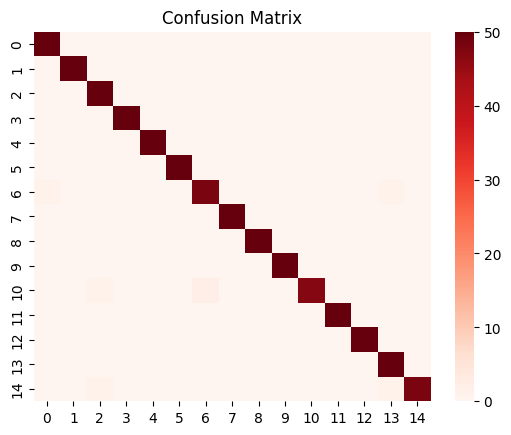

In [34]:
# Plot confusion matrix
cm = confusion_matrix(final_targets, final_predictions)
print(cm)


sns.heatmap(cm,  cmap='Reds')
plt.title("Confusion Matrix")

plt.show()

In [35]:
## Define another MobileNet model
## Replace the final fully connected layer with a new FC layer matching the number of classes proceed with training. (second model)
model_mob2 = models.mobilenet_v2(weights=models.MobileNet_V2_Weights.IMAGENET1K_V1) # Load the pre-trained MobileNet model


# Unfreeze the all layers
in_features_m2 = model_mob2.classifier[1].in_features
model_mob2.classifier[1] = nn.Linear(in_features_m2, num_classes)

for param in model_mob2.parameters():
    param.requires_grad = True

model_mob2 = model_mob2.to(device)

criterion_mob2 = nn.CrossEntropyLoss() # Define the loss function.
optimizer_mob2 = optim.Adam(model_mob2.parameters(), lr=1e-4) # Define optimizer


# Train the model using our helper function.
model_mob2, train_losses_mob2, val_losses_mob2, train_accs_mob2, val_accs_mob2 = train_transfer_model(
    model        = model_mob2,
    train_loader = train_loader,
    val_loader   = val_loader,
    criterion    = criterion_mob2,
    optimizer    = optimizer_mob2,
    num_epochs   = 43,
)




Epoch 1/43
Train Loss: 0.5746 | Train Acc: 0.8753
Val Loss: 0.0493 | Val Acc: 0.9947

Epoch 2/43
Train Loss: 0.0850 | Train Acc: 0.9850
Val Loss: 0.0165 | Val Acc: 0.9973

Epoch 3/43
Train Loss: 0.0410 | Train Acc: 0.9923
Val Loss: 0.0080 | Val Acc: 1.0000

Epoch 4/43
Train Loss: 0.0218 | Train Acc: 0.9970
Val Loss: 0.0072 | Val Acc: 0.9987

Epoch 5/43
Train Loss: 0.0268 | Train Acc: 0.9950
Val Loss: 0.0083 | Val Acc: 0.9987

Epoch 6/43
Train Loss: 0.0218 | Train Acc: 0.9953
Val Loss: 0.0143 | Val Acc: 0.9960

Epoch 7/43
Train Loss: 0.0128 | Train Acc: 0.9980
Val Loss: 0.0067 | Val Acc: 0.9987

Epoch 8/43
Train Loss: 0.0231 | Train Acc: 0.9953
Val Loss: 0.0158 | Val Acc: 0.9947

Epoch 9/43
Train Loss: 0.0288 | Train Acc: 0.9930
Val Loss: 0.0096 | Val Acc: 0.9987

Epoch 10/43
Train Loss: 0.0303 | Train Acc: 0.9917
Val Loss: 0.0324 | Val Acc: 0.9893

Epoch 11/43
Train Loss: 0.0145 | Train Acc: 0.9980
Val Loss: 0.0057 | Val Acc: 0.9973

Epoch 12/43
Train Loss: 0.0135 | Train Acc: 0.9953
V

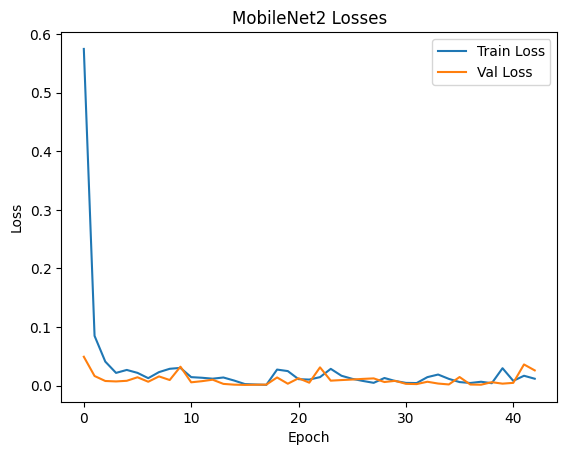

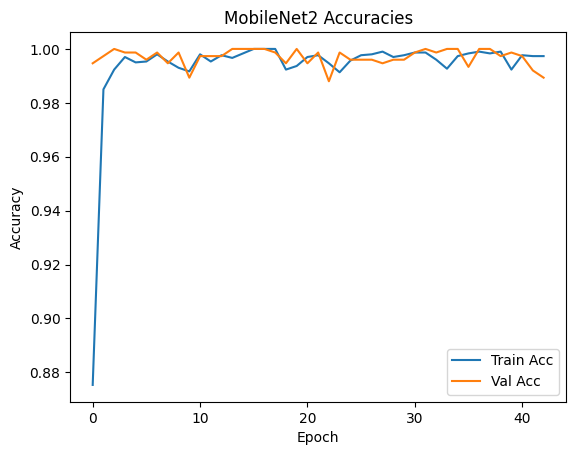

In [36]:
## Define appropriate loss function and optimizer for training
## Iterate over the training dataset in mini-batches, compute the loss, and update model parameters.
## Monitor the training process and evaluate all model's performance on the validation set periodically.
## Visualize the accuracy and loss changes of the models across training and validation datasets.

## Compute metrics such as accuracy, precision, recall, and F1-score to assess classification performance.
## Visualize confusion matrix to understand the model's behavior across different classes

# Plot loss and accuracy for epoch using saved numpy arrays
plt.figure()
plt.title("MobileNet2 Losses")
plt.plot(train_losses_mob2, label="Train Loss")
plt.plot(val_losses_mob2, label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure()
plt.title("MobileNet2 Accuracies")
plt.plot(train_accs_mob2, label="Train Acc")
plt.plot(val_accs_mob2, label="Val Acc")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [37]:
model_mob2.eval()# Eval mode

# Store predictions and targets for evaluation metrics
store_preds = []
store_targets = []

with torch.no_grad():# Do not compute gradient
    for data, target in val_loader:# Iterate over all mini-batches

        # Move data to GPU
        data = data.to(device)
        target = target.to(device)

        # Forward pass
        out = model_mob2(data)
        
        _, prediction_indices = torch.max(out, 1)

        
        store_preds.append(prediction_indices)
        store_targets.append(target)

# Convert lists to numpy arrays
final_predictions = torch.cat(store_preds).cpu().numpy()
final_targets = torch.cat(store_targets).cpu().numpy()

# Compute evaluation metrics
acc = accuracy_score(final_targets, final_predictions)
prec = precision_score(final_targets, final_predictions, average='macro')
rec    = recall_score(final_targets, final_predictions, average='macro')
f1        = f1_score(final_targets, final_predictions, average='macro')

# Print
print("Validation :", acc)
print("Precision :", prec)
print("Recall :", rec)
print("F1 Score :", f1)




Validation : 0.9893333333333333
Precision : 0.9896056898811774
Recall : 0.9893333333333333
F1 Score : 0.9893295044023219


[[50  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0 50  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 49  0  0  0  0  0  0  0  1  0  0  0  0]
 [ 0  0  0 50  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 49  0  1  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0 50  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  2  0  0 48  0  0  0  0  0  0  0  0]
 [ 1  0  0  0  0  0  0 49  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 50  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  3 47  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0 50  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 50  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0 50]]


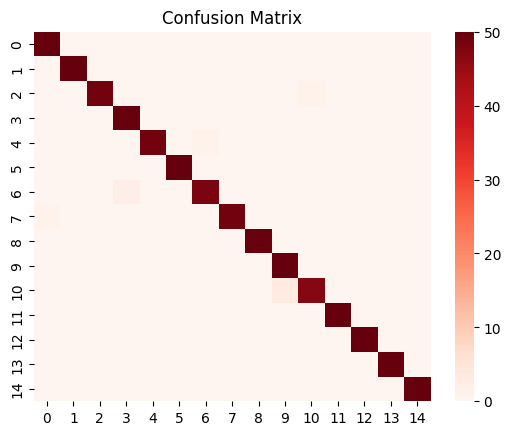

In [38]:
# Plot confusion matrix
cm = confusion_matrix(final_targets, final_predictions)
print(cm)


sns.heatmap(cm,  cmap='Reds')
plt.title("Confusion Matrix")

plt.show()

Conduct a comparative analysis among these two models. Comment on their performance and select your best model with respect to validation accuracy.
* Which model performed better and why do you think it performed better?  
* Comment on the practical considerations among these models also.

The best performance was achieved by the second model because fine tuning all layers allows it to fully learn the characteristics of the vegetable dataset. All weights were updated, so the model learned the most optimal features for this specific dataset.

Only FC Layer Trained (Model 1) had the shortest training time because we trained a single layer. However, because not all features were updated, it scored lower compared to the other models. This model had the least GPU usage. It has the least risk of overfitting.

Model 2 had the longest training time and the highest accuracy. This is because we trained all layers. GPU usage was the highest. It also had the highest risk of overfitting.

In cases where the dataset is small, meaning the model is prone to overfitting, and in cases where time and GPU resources are limited, Model 1 will be more suitable.

In cases where the dataset is large and resources are plentiful, Model 2 will be the best option.

### 2.9 Evaluate the fine-tuned MobileNet model (5 points)

In [39]:
## Test the best model on the test set to evaluate its performance.
## Comment on the results

## Test the best model on the test set to evaluate its performance.
## Comment on the results
## Compare the fine-tuned ResNet18 model performance with the CNN model implemented from scratch


# Model is on the GPU and in evaluation mode
model_mob2.to(device)
model_mob2.eval()

# class_names maps predicted indices
class_names = train_dataset.classes   

ids = []
labels = []

# Disable gradient computation 
with torch.no_grad():
    for images, img_names in test_loader:
        images = images.to(device) # Move test images to device

        outputs = model_mob2(images)# Forward pass 
        preds = outputs.argmax(dim=1).cpu().numpy() # Get predicted class indices for each image

        # Convert indices into class names
        pred_names = []
        for p in preds:
            class_name_idx=class_names[p]
            pred_names.append(class_name_idx)

        # Add the batch results
        ids.extend(img_names)
        labels.extend(pred_names)


# Create a DataFrame in the format required by Kaggle:
submission_df = pd.DataFrame({
    "Id": ids,
    "label": labels
})

# Save the submission file
submission_df.to_csv("submission_mobilenet.csv", index=False)



In [40]:
## Compare the best fine-tuned MobileNet model performance with the best CNN model implemented from scratch
## Compare the best fine-tuned MobileNet model performance with the best ResNet18 model implemented from scratch

The best fine-tuned MobileNet model achieved 99.7% test accuracy, while the CNN model implemented from scratch reached 98.6% accuracy.

This comparison shows that the model we used for transfer learning performed much better. The CNN from scratch model attempted to learn all features from just 3000 images, whereas MobileNet was pretrained on ImageNet, which contains over 1 million images across 1000 categories. This provides a significant advantage in feature learning. We only fine-tuned the model to make it compatible with our dataset.

The best fine-tuned MobileNet achieved 99.7% test accuracy, while the best ResNet18 model achieved 99.5%. While this is a small difference, MobileNet is ahead.

This is because MobileNet is more efficient and performs better on smaller datasets. ResNet, on the other hand, performs better in applications with larger datasets.

### 2.10 Kaggle Test Result (5 points)
* Put your Kaggle test result for your MobileNet pretrained model here.
* You will get a score between 0-1 and your percentage (e.g. 0.1, 0.3, 0.6, 0.85) of accuracy will be multiplied by the highest possible score (5 points) for this part. That will be your grading score.

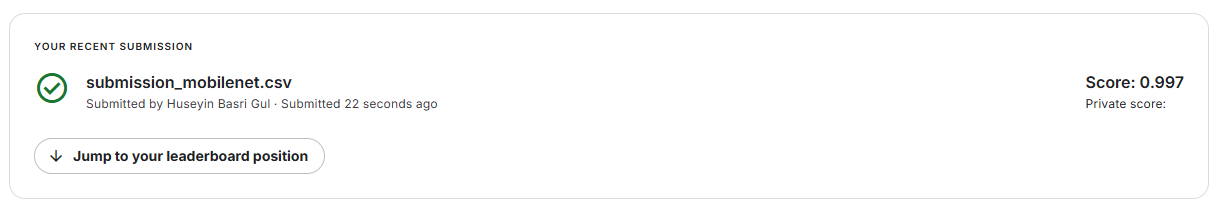

## 3 Analyze advantages and disadvantages (7 points)

* Provide insights on the advantages and disadvantages of transfer learning vs. training from scratch
* Put a table for comparison of the best 3 models that you have obtained in this assignment (CNN from scratch, ResNet18, MobileNet)
* Discuss practical considerations when choosing between these approaches and models.



In this assignment, the CNN model trained from scratch achieved 98.6% test accuracy, whereas the fine-tuned MobileNet and ResNet18 models reached 99.7% and 99.5%, respectively. This clearly demonstrates the advantage of using a transfer learning model.

Transfer learning models are better at handling data because training a CNN network with 3000 datasets can lead to overfitting, while ResNet/MobileNet have already seen millions of images. Therefore, these models generalize better.

Using transfer learning is much more advantageous than writing a CNN model from scratch in terms of training time and GPU usage because the Transfer Learning model is already trained; by fine-tuning just a few layers, we can achieve more efficient and accurate results.

If I must tell you one disadvantage is that the CNN from scratch is much more flexible, meaning we can shape the layers and architecture as we wish, which is more suitable for students like me or for scientific purposes.

ON VALIDATION SET

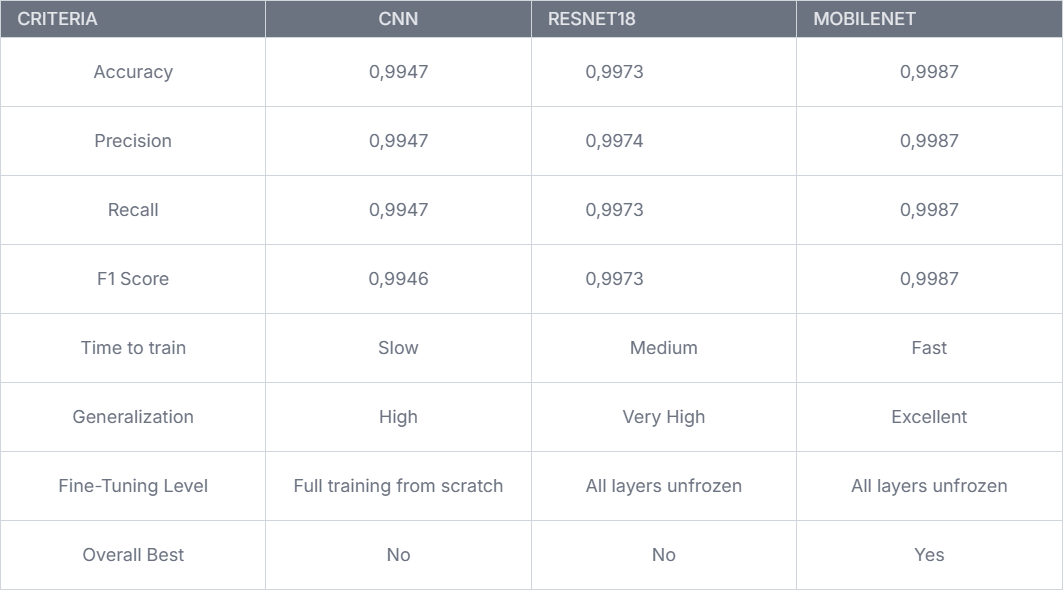

Training from scratch is useful for very large datasets, but if the dataset is small, large neural networks are likely to memorize and overfit it. Transfer learning, on the other hand, is more advantageous for smaller datasets, offering shorter training times and higher accuracy.

Training from scratch is more sensitive to hyperparameters. However, because transfer learning models are already well-prepared, they are less affected by hyperparameters than training from scratch models. If time/GPU constraints are limited and you need to produce a working model quickly, transfer learning is best.

If your goal is learning, exploring new architectures, or scientific, training from scratch is better. These models give you full control. However, this is not possible with transfer learning models because they use a pre-built architecture.

Between the two pretrained architectures, MobileNet is a much more suitable model for our dataset because ResNet18 is a deeper and more powerful architecture for general-purpose vision tasks, while MobileNet has fewer parameters. Therefore, it generalizes better on small datasets.